# Load modules

In [23]:
import os
import cv2
import sys
import glob
import imageio
import numpy as np
import pandas as pd
import pydicom as dcm
import matplotlib.pyplot as plt
from datetime import datetime as dtime


# Auxiliar Functions

In [3]:
def displayDICOMimage(DICOMobj):
    plt.figure(1)
    plt.imshow(DICOMobj.pixel_array,plt.cm.gray)
    plt.show()

def getenv():
    """
    Requires sys and os modules:
    import sys
    import os
    """
    if sys.platform == 'win32':
        env_home = 'HOMEPATH'
    elif (sys.platform == 'darwin') | (sys.platform == 'linux'):
        env_home = 'HOME'
    HOMEPATH = os.getenv(env_home)
    
    return HOMEPATH

def check_path_exist(path, file=False):
    """
    Flag FILE indicates the path contains a file name (FLAG=TRUE) or the path only points to a folder (FLAG=FALSE (Default))
    """
    if file:
        is_path = os.path.isfile(path)
    else:
        is_path = os.path.isdir(path)

    print(f'{"OK:" if is_path else "ERROR:"} Path to {"file" if file else "folder"} {path} does{"" if is_path else " NOT"} exist')

    return is_path

def list_folder(path, skip_patterns=None, sorted=False):
    # Check the path exists:
    if not(os.path.isdir(path)):
        error_message = f'[ERROR]: Folder path {path} does not exist'
        sys.exit(error_message)
    
    raw_list = os.listdir(path)
    
    # Ensure patterns is a list, defaulting to ['.DS_Store']
    dsStorePattern = '.DS_Store'
    if skip_patterns is None:
        skip_patterns = [dsStorePattern]
    elif isinstance(skip_patterns, str):
        skip_patterns = [dsStorePattern, skip_patterns]  # Convert single string to list
    elif isinstance(skip_patterns, (list, tuple, set)):  
        skip_patterns = list(skip_patterns)  # Ensure it's a list
        if dsStorePattern not in skip_patterns:
            skip_patterns.append(dsStorePattern)  # Add default pattern if not already included
    else:
        raise TypeError("patterns must be a string, list, tuple, or set.")

    # dir_list = [item for item in raw_list if skip_pattern not in item]
    # any(p in item for p in skip_patterns) checks if any pattern in skip_patterns exists in item:
    dir_list = [item for item in raw_list if not any(p in item for p in skip_patterns)]

    if sorted:
        dir_list.sort()

    return dir_list


# Function to parse mixed datetime formats
def parse_mixed_datetime(ts, format='%Y%m%d%H%M%S.%f'):
    """
    # Ensure all values have milliseconds (force `.0000` if missing) before the conversion:
    """

    ts_f = ts.apply(lambda x: f"{x}.0000" if pd.notna(x) and "." not in str(x) else x)

    return pd.to_datetime(ts_f, format=format, errors="coerce")
    

In [4]:
HOMEPATH = getenv()
FEXT = 'dcm'


# Phase 1 - 2024

In [9]:
# # If running data from Phase 1 (2024), this is the path to raw DICOM:
# DATAPATH = os.path.join(HOMEPATH, 'Data', 'fMRIBreastData', 'rawStudyData')
# # Check whether the DATAPATH route exists or not:
# _ = check_path_exist(DATAPATH)


In [10]:
# dcmlist = glob.glob(os.path.join(DATAPATH,f'*.{FEXT}'))
# print(f'There are {len(dcmlist)} files in {DATAPATH}')


In [11]:
# ds = dcm.dcmread(dcmlist[0])
# displayDICOMimage(ds)


In [12]:
# Tag2proc = {'SliceLocation':{'hex': [0x00201041],
#                              'type': 'float32'
#                             },
#             'InstanceNumber':{'hex': [0x00200013],
#                               'type': 'int'
#                              },
#             'PatientName': {'hex': [0x00100010],
#                             'type': 'string'
#                             },
#             'PatientID': {'hex': [0x0010020],
#                           'type': 'string'
#                          },
#             'ScanOptions': {'hex': [0x00180022],
#                             'type': 'decimal'
#                             },
#             'SliceThickness': {'hex': [0x00180050],
#                                'type': 'float32'
#                                },
#             'RepetitionTime': {'hex': [0x00180080],
#                                'type': 'float32'
#                                },
#             'EchoTime': {'hex': [0x00180081],
#                          'type': 'float32'
#                          },
#             'FlipAngle': {'hex': [0x00181314],
#                           'type': 'float32'
#                           }
#            }

# ImgZpos = []
# for dcm in dcmlist:
#     ds = dcm.dcmread(dcm,stop_before_pixels=True)
#     newrow = []
#     for tagName, tagValue in Tag2proc.items():
#         try:
#             newrow.append(ds[tagName].value)
#         except:
#             print(f'Attribute {tagName} does not exist, skipping it...')

#     ImgZpos.append(newrow)


In [13]:
# zPos = pd.DataFrame(ImgZpos, columns=list(Tag2proc.keys())).astype({'PatientName':'string', 'PatientID': 'string'})#, dtype=[str, int, float])
# zPos.sort_values(by=['InstanceNumber'], inplace=True)
# zPos['DeltaZ'] = zPos['SliceLocation'].diff()
# zPos.head(n=10)


In [14]:
# a = list(zPos.PatientName.unique())
# a.sort()

# for name in a:
#     print(f'{name} (ID: {zPos[zPos["PatientName"]==name]["PatientID"].unique()[0]})')


# Phase 2 - 2025

In [5]:
# If running data from Phase 2 (2025), raw data structure is more organised:
DATAPATH = os.path.join(HOMEPATH, 'Data', 'FTV_DCEMRI_Phase02')
DICOMPATH = os.path.join(DATAPATH, 'DICOM')
OUTPATH = os.path.join(DATAPATH, 'preliminary_review')
# Inside DICOM, there is a list of patients with each one containing the study date and inside them, the data:
!tree -L 3 {DICOMPATH} 


/Users/joseulloa/Data/FTV_DCEMRI_Phase02/DICOM
├── 001
│   ├── 2022-10__Studies
│   │   ├── NE001_ANON58704_MR_2022-10-26_135058_MRI.Sim.Breast.Prone.+.Contrast_4D.THRIVE.Ultrafast_n2400__00000
│   │   ├── NE001_ANON58704_MR_2022-10-26_135058_MRI.Sim.Breast.Prone.+.Contrast_Dyn.eTHRIVE_n1080__00000
│   │   ├── NE001_ANON58704_MR_2022-10-26_135058_MRI.Sim.Breast.Prone.+.Contrast_FA15.THRIVE.map_n120__00000
│   │   └── NE001_ANON58704_MR_2022-10-26_135058_MRI.Sim.Breast.Prone.+.Contrast_FA5.THRIVE.map_n120__00000
│   └── 2022-12__Studies
│       ├── NE001_ANON58704_MR_2022-12-15_103927_MRI.Sim.Breast.Prone.+.Contrast.Post.Tmt_4D.TH_n2400__00000
│       ├── NE001_ANON58704_MR_2022-12-15_103927_MRI.Sim.Breast.Prone.+.Contrast.Post.Tmt_Dyn.eTHRIVE_n1080__00000
│       ├── NE001_ANON58704_MR_2022-12-15_103927_MRI.Sim.Breast.Prone.+.Contrast.Post.Tmt_FA15.THRIVE.map_n120__00000
│       └── NE001_ANON58704_MR_2022-12-15_103927_MRI.Sim.Breast.Prone.+.Contrast.Post.Tmt_FA5.THRIVE.map_n120__00000

In [6]:
Tag2proc = {
'ID': { # Patient and Study ID
            'StudyID': {'hex': 0x00200010,
                         #  'type': str
                         },
            'PatientName': {'hex': 0x00100010,
                         #    'type': str
                            },
            'PatientID': {'hex': 0x00100020,
                         #  'type': str
                         }
     },
'SeriesID': { # Acquisitions and Series ID
            'SeriesDescription': {'hex': 0x0008103e,
                         #  'type': str
                         },
            'SeriesNumber': {'hex': 0x00200011,
                         #  'type': pd.Int64Dtype()
                         },
            'AcquisitionNumber': {'hex': 0x00200012,
                              #     'type': pd.Int64Dtype()
                                  },
            'InstanceNumber':{'hex': 0x00200013,
                              # 'type': pd.Int64Dtype()
                             }
            # 'ImagesInAcquisition': {'hex': 0x00201002,
            #                   #     'type': pd.Int64Dtype()
            #                       }
          },
'DatesTimes': { #  Dates & Times
            'StudyDate': {'hex': 0x00080020,
                         #  'type': str
                         },
            'StudyTime': {'hex': 0x00080030,
                         #  'type': str
                         },
            'SeriesDate': {'hex': 0x00080021,
                         #  'type': str
                         },
            'SeriesTime': {'hex': 0x00080031,
                         #  'type': str
                         },
            'AcquisitionDate': {'hex': 0x00080022,
                         #  'type': str
                         },
            'AcquisitionTime': {'hex': 0x00080032,
                         #  'type': str
                         },
          #   'AcquisitionDateTime': {'hex': 0x0008002A,
          #                          'type': str
          #                },
            'AcquisitionDuration': {'hex': 0x00189073, # Duration of the single continuous gathering of data over a period of time that resulted in this instance, in seconds.
                                   #  'type': pd.Float64Dtype()
                                    },
            'ContentDate': {'hex': 0x00080023,
                         #  'type': str
                         },
            'ContentTime': {'hex': 0x00080033,
                         #    'type': str
                            },
            'InstanceCreationDate': {'hex': 0x00080012,
                         #  'type': str
                         },
            'InstanceCreationTime': {'hex': 0x00080013,
                         #  'type': str
                         },
            'PerformedProcedureStepEndDate': {'hex': 0x00400250,
                         #  'type': str
                         },
            'PerformedProcedureStepEndTime': {'hex': 0x00400251,
                         #  'type': str
                         }
          },
'AcqPars': { # Acquisition Parameters
            'ImageType': {'hex': 0x00080008,
                        #   'type': 
                        },
            'ScanningSequence': {'hex': 0x00180020,
                                 },
            'SequenceVariant': {'hex': 0x00180021,
                                 },
            'ScanOptions': {'hex': 0x00180022, # Parameters of scanning sequence.
                         #    'type': str
                            },
            'MRAcquisitionType': {'hex': 0x00180023,
                              #     'type': str
                                  },
            'SequenceName': {'hex': 0x00180024, 
                         #    'type': str
                            },
            'RepetitionTime': {'hex': 0x00180080,
                              #  'type': pd.Float64Dtype()
                               },
            'EchoTime': {'hex': 0x00180081,
                         # 'type': pd.Float64Dtype()
                         },
            'FlipAngle': {'hex': 0x00181314,
                         #  'type': pd.Float64Dtype()
                          },
            'InversionTime': {'hex': 0x00180082,
                              # 'type': pd.Float64Dtype()
                         },
            'NumberOfAverages': {'hex': 0x00180083,
                              # 'type': pd.Int64Dtype()
                         },
            'NumberOfPhaseEncodingSteps': {'hex': 0x00180089,
                                        #    'type': pd.Int64Dtype()
                                           },
            'EchoTrainLength': {'hex': 0x00180091,
                              #   'type': pd.Int64Dtype()
                                },
            'PercentSampling': {'hex': 0x00180093,
                              #   'type': pd.Float64Dtype()
                                },
            'PercentPhaseFieldOfView': {'hex': 0x00180094,
                                        # 'type': pd.Float64Dtype()
                                        },
            'PixelBandwidth': {'hex': 0x00180095,
                              #  'type': pd.Float64Dtype()
                               },
            'TriggerTime': {'hex': 0x00181060, # Time, in msec, between peak of the R wave and the peak of the echo produced
                         #    'type': pd.Float64Dtype()
                            },
            'InPlanePhaseEncodingDirection': {'hex': 0x00181312,
               #   'type': str
                 },
            'TemporalPositionIdentifier': {'hex': 0x00200100,
               #   'type': str
                 },
            'NumberOfTemporalPositions': {'hex': 0x00200105,
                                        #   'type': str
                                          },
            # 'TemporalResolution': {'hex': 0x00200110,
            #                             #   'type': str
            #                               },
            'SliceLocation':{'hex': 0x00201041,
                         #     'type': pd.Float64Dtype()
                            },
            'ImagePositionPatient':{'hex': 0x00200032,
                                   #  'type': object
                                    },
            'SliceThickness': {'hex': 0x00180050,
                              #  'type': pd.Float64Dtype()
                               },
            'SpacingBetweenSlices': {'hex': 0x00180088,
                                   #   'type': pd.Float64Dtype()
                              },
            'ImageOrientationPatient': {'hex': 0x00200037,
                                        # 'type': object
                              },
          },
'ImagePars': { # Reconstruction/Image Parameters
            'AcquisitionMatrix': {'hex': 0x00181310,
                              #     'type': object
                                  },
            'PixelSpacing': {'hex': 0x00280030,
                         #     'type': object
                             },
            'Rows': {'hex': 0x00280010,
                    #  'type': pd.Int64Dtype()
                     },
            'Columns': {'hex': 0x00280011,
                    #     'type': pd.Int64Dtype()
                        },
            # 'PixelAspectRatio': {'hex': 0x00280034,
            #                   #    'type': object
            #                      },
            'ReconstructionDiameter': {'hex': 0x00181100,
                                   #     'type': pd.Float64Dtype()
                                       },
            'RescaleType': {'hex': 0x00281054,
                         #    'type': str
                            },
            'RescaleIntercept': {'hex': 0x00281052, # RI
                         #    'type': pd.Float64Dtype()
                            },
            'RescaleSlope': {'hex': 0x00281053, # RS
                         #    'type': pd.Float64Dtype()
                            },
            # 'PhilipsRWVSlope': {'hex': 0x00409225,  # Philips Private Attribute
            #                   #   'type': pd.Float64Dtype()
            #                    },
            # 'PhilipsRWVIntercept': {'hex': 0x00409224,  # WI, Philips Private Attribute
            #                        #  'type': pd.Float64Dtype()
            #                         },
            'PhilipsScaleSlope': {'hex': 0x2005100E, # SS, Philips Private Attribute
                              #     'type': pd.Float64Dtype()
                                  }
            # 'PhaseNumber': {'hex': 0x20011008, # Philips Private Attribute
            #              #    'type': pd.Int64Dtype()
            #                 }
          },
'ContrastAgent': { # Contrast Agent
            'ContrastBolusAgent': {'hex': 0x00180010,
                         #  'type': str
                         },
            'ContrastBolusRoute': {'hex': 0x00181040,
                         #  'type': str
                         },
            'ContrastBolusVolume': {'hex': 0x00181041,
                         #  'type': pd.Float64Dtype()
                         },
            'ContrastBolusStartTime': {'hex': 0x00181042,
                         #  'type': pd.Float64Dtype()
                         },
            'ContrastBolusStopTime': {'hex': 0x00181043,
                         #  'type': pd.Float64Dtype()
                         },
            'ContrastBolusTotalDose': {'hex': 0x00181044,
                         #  'type': pd.Float64Dtype()
                         },
            'ContrastFlowRate': {'hex': 0x00181046,
                         #  'type': pd.Float64Dtype()
                         },
          }
   }

metaDataSuperSet = Tag2proc.keys()
metaDataFields = []
dtype_df_dict = {}
# default_row_list = {}
for metaDataField in metaDataSuperSet:
    subsetDataLabels = list(Tag2proc[metaDataField].keys())
    metaDataFields += subsetDataLabels
   #  for subsetDataLabel in subsetDataLabels:
   #     dtype_df_dict[subsetDataLabel] = Tag2proc[metaDataField][subsetDataLabel]['type']
      #  default_row_list[subsetDataLabel] = Tag2proc[metaDataField][subsetDataLabel]['default']

# Add the absolute filepath to the dataframe:
metaDataFields.append('AbsFilePath')


In [7]:
# Get the list of outer folders (Patient Keys):
patientsList = list_folder(DICOMPATH, sorted=True)
dicomMetadataList = []

# Construct the dataframe for each patient
#   1)  Inside each patient, there should be one or two folders, 
#       corresponding to the study date (i.e. at least 2 visits per patient)
for patient in patientsList:
    path_to_patient = os.path.join(DICOMPATH, patient)
    print(f'Processing patient {patient} folder {path_to_patient}')
    # Get the study dates:
    visit_dates = list_folder(path_to_patient, sorted=True)
    print(f'Patient {patient} folder contains sub-folders: {visit_dates}')
    for visit in visit_dates:
        path_to_visit = os.path.join(path_to_patient, visit)
        # Get series within the study date:
        series_list = list_folder(path_to_visit, sorted=True)
        print(f'Visit {visit} folder containts the {len(series_list)} scan series')
        # Loading the dcm files on each series folder:
        for series in series_list:
            path_to_series = os.path.join(path_to_visit, series)
            # Get the list of DCM (or whatever is defined by FEXT) files:
            dcmlist = glob.glob(os.path.join(path_to_series,f'*.{FEXT}'))
            print(f'There are {len(dcmlist)} files in {"-".join([patient, visit, series])}')
            print('Loading dicom files, please wait...')
            for dcmfile in dcmlist:
                dcm_metadata = dcm.dcmread(dcmfile,stop_before_pixels=True)
                newrow = [None]*len(metaDataFields)
                for tagSubSetName, tagSubSetFields in Tag2proc.items():
                    for tagName, tagValue in tagSubSetFields.items():
                        try:
                            newrow[metaDataFields.index(tagName)] = dcm_metadata[tagValue['hex']].value
                            # newrow.append(dcm_metadata[Tag2proc[tagName]['hex']].value)
                        except:
                            # print(f'Attribute {tagName} does not exist, skipping it...')
                            pass
                # Add the filepath:
                newrow[metaDataFields.index('AbsFilePath')] = dcmfile
                dicomMetadataList.append(newrow)


Processing patient 001 folder /Users/joseulloa/Data/FTV_DCEMRI_Phase02/DICOM/001
Patient 001 folder contains sub-folders: ['2022-10__Studies', '2022-12__Studies']
Visit 2022-10__Studies folder containts the 4 scan series
There are 2400 files in 001-2022-10__Studies-NE001_ANON58704_MR_2022-10-26_135058_MRI.Sim.Breast.Prone.+.Contrast_4D.THRIVE.Ultrafast_n2400__00000
Loading dicom files, please wait...
There are 1080 files in 001-2022-10__Studies-NE001_ANON58704_MR_2022-10-26_135058_MRI.Sim.Breast.Prone.+.Contrast_Dyn.eTHRIVE_n1080__00000
Loading dicom files, please wait...
There are 120 files in 001-2022-10__Studies-NE001_ANON58704_MR_2022-10-26_135058_MRI.Sim.Breast.Prone.+.Contrast_FA15.THRIVE.map_n120__00000
Loading dicom files, please wait...
There are 120 files in 001-2022-10__Studies-NE001_ANON58704_MR_2022-10-26_135058_MRI.Sim.Breast.Prone.+.Contrast_FA5.THRIVE.map_n120__00000
Loading dicom files, please wait...
Visit 2022-12__Studies folder containts the 4 scan series
There are 

In [8]:
df_metadata = pd.DataFrame(columns=metaDataFields, data=dicomMetadataList)#.astype(dtype_df_dict)
# Create datetime objects for the paired date and time attributes
date_time_attr = ['InstanceCreation', 'Study', 'Series', 'Acquisition', 'Content']

for datetime_tagName in date_time_attr:
    date_attr = datetime_tagName+'Date'
    time_attr = datetime_tagName+'Time'
    df_metadata[datetime_tagName+'DateTime'] = parse_mixed_datetime(df_metadata[date_attr] + df_metadata[time_attr])

# Additionally, merges the Study Date with Contrast Start/End to ensure they fit in the acquisition window:
df_metadata['ContrastBolusStartDateTime'] = parse_mixed_datetime(df_metadata['StudyDate'] + df_metadata['ContrastBolusStartTime'])
df_metadata['ContrastBolusEndDateTime'] = parse_mixed_datetime(df_metadata['StudyDate'] + df_metadata['ContrastBolusStopTime'])

# Ensures PatientName is a string:
df_metadata['PatientName'] = df_metadata['PatientName'].astype(str)

# Setup a per-slice timing:
# For each Series do the following:
#   - Sort, in ascending order, the TemporalPositionIdentifier
#   - Sort, in ascending order, the slice location (from - to +)
#   - Based on the dataframe index, loop over the Temporal position and populate the new field AcquisitionDateTimeSlice:
# 
df_metadata['perSliceAcquisitionTime'] = [None]*len(df_metadata)
df_metadata['perSliceAcquisitionTimeInSecs'] = [None]*len(df_metadata)
df_metadata['ContrastBolusStartTimeInSecs'] = [None]*len(df_metadata)

# Patient List:
patientList = df_metadata['PatientName'].unique().tolist()
for patient in patientList:
    # Studies List for each patient:
    patient_in_df = df_metadata[df_metadata['PatientName'].isin([patient])]
    studies_in_patient = patient_in_df['StudyDate'].unique().tolist()
    for study_patient in studies_in_patient:
        study_in_patient = patient_in_df[patient_in_df['StudyDate'].isin([study_patient])]
        sequences_in_study = study_in_patient['SeriesDescription'].unique().tolist()
        # min acquisition time between Dyn eTHRIVE and 4D_THRIVE:
        df_aux = study_in_patient[(study_in_patient['SeriesDescription'].str.startswith('4D_THRIVE')) | (study_in_patient['SeriesDescription'].str.startswith('Dyn'))]
        min_time = df_aux['AcquisitionDateTime'].min(skipna=True)
        for sequence_study_patient in sequences_in_study:
            # We're now at the level of series.
            # For the timming, we're only interested in 4D_THRIVE_Ultrafast & Dyn eTHRIVE:
            if sequence_study_patient.startswith('4D_THRIVE') | sequence_study_patient.startswith('Dyn'):
                serie_in_study = study_in_patient[study_in_patient['SeriesDescription'].isin([sequence_study_patient])]
                # Additional Filter to remove the corrupted single file:
                serie_in_study = serie_in_study[serie_in_study['AcquisitionNumber'].notna()]
                # Now, we should be ready to assign the timings:
                # Sort by temporal position:
                serie_in_study.sort_values(by=['TemporalPositionIdentifier', 'SliceLocation'], ascending=(True, False), inplace=True)
                nslices = len(serie_in_study['SliceLocation'].unique().tolist())
                slice_order = range(0, nslices)
                # Here loop over TimePos and slice location using the formula:
                # AcquisitionTime  + TR * TempPos * Range(Slice)
                TR = serie_in_study['RepetitionTime'].unique().tolist()
                if len(TR) > 1:
                    print(f'WARNING!: There are more than 1 TR ({TR}) in the series. Using the first one available')
                # else:
                    # print(f'TR: {TR[0]}ms')
                TR = TR[0]

                nt = serie_in_study['NumberOfTemporalPositions'].unique().tolist()
                if len(nt) > 1:
                    print(f'ERROR: The number of temporal positions {nt} is not consistent through the series')
                    sys.exit()
                # else:
                    # print(f'Number of Temporal Positions: {nt[0]}')                
                nt = int(nt[0])
                slices_positions = list(slice_order)*nt
                perSliceAcquisitionDateTime = pd.to_timedelta([z*TR/1000.0 for z in slices_positions], unit='s')
                # serie_in_study['perSliceAcquisitionDateTime'] = [None]*len(serie_in_study)
                serie_in_study['perSliceAcquisitionDateTime'] = serie_in_study['AcquisitionDateTime'] + perSliceAcquisitionDateTime
                
                # Find the earliest AcquisitionEndTime (ignoring NaT values) -- But the min time in my case, is the start of the Dyn eTHRIVE acquisition
                # min_time = serie_in_study['perSliceAcquisitionDateTime'].min(skipna=True)
                # Compute time differences in seconds for the acquisition and contrast bolus
                serie_in_study['perSliceAcquisitionTimeInSecs'] = (serie_in_study['perSliceAcquisitionDateTime'] - min_time).dt.total_seconds()
                serie_in_study['ContrastBolusStartTimeInSecs'] = (serie_in_study['ContrastBolusStartDateTime'] - min_time).dt.total_seconds()

                df_metadata.loc[serie_in_study.index, 'perSliceAcquisitionDateTime'] = serie_in_study['perSliceAcquisitionDateTime']
                df_metadata.loc[serie_in_study.index, 'perSliceAcquisitionTimeInSecs'] = serie_in_study['perSliceAcquisitionTimeInSecs']
                df_metadata.loc[serie_in_study.index, 'ContrastBolusStartTimeInSecs'] = serie_in_study['ContrastBolusStartTimeInSecs']

                # for index, tpos, zpos in zip(serie_in_study.index, serie_in_study['TemporalPositionIdentifier'], slices_positions):
                #     # # df_metadata.loc[index, 'perSliceAcquisitionTime'] = TR*zpos
                #     serie_in_study.loc[index, 'perSliceAcquisitionDateTime'] = TR*zpos
                


# convert df_metadata['perSliceAcquisitionTime'] to numeric and then to timedelta in seconds:
# df_metadata['perSliceAcquisitionTime'] = pd.to_timedelta(pd.to_numeric(df_metadata['perSliceAcquisitionTime'], errors='coerce'), unit='ms')
# And then sum up the Acquisition DateTime so it becomes datetime too:
# df_metadata['perSliceAcquisitionDateTime'] = df_metadata['AcquisitionDateTime'] + df_metadata['perSliceAcquisitionTime']
# Add time axis in minutes too:
df_metadata[['perSliceAcquisitionTimeInMins', 'ContrastBolusStartTimeInMins']] = df_metadata[['perSliceAcquisitionTimeInSecs', 'ContrastBolusStartTimeInSecs']]/60.0

# Saves the dataframe as CSV
df_metadata.to_csv(os.path.join(OUTPATH, 'initial_qc.csv'))
df_metadata.head()

# Slicer3D uses the image position patient coordinate, rather than SliceLocation:
df_metadata[['x','y','z']] = df_metadata['ImagePositionPatient'].apply(pd.Series)


In [9]:
# Here describe the df to summarise the relevant QC parameters
# MRI Parameters:
groupby = ['PatientID','StudyID','StudyDate','StudyTime','SeriesNumber','SeriesDescription']

print(f'Super Sets: {list(Tag2proc.keys())}')


Super Sets: ['ID', 'SeriesID', 'DatesTimes', 'AcqPars', 'ImagePars', 'ContrastAgent']


In [10]:
# QC dates and time of acquisitions and contrast agent injection
subSetDateAndTime = list(dict.fromkeys(list(Tag2proc['DatesTimes'].keys()) + list(Tag2proc['ContrastAgent'].keys())))
# selectedFields = list(set(groupby + subSetDateAndTime))
# to maintain the original order of elements while ensuring uniqueness:
selectedFields = list(dict.fromkeys(groupby + subSetDateAndTime))
df_subFields = df_metadata[selectedFields].groupby(groupby).describe()
df_output = df_subFields.loc[:, df_subFields.columns.get_level_values(1) == 'top'] # Look at only the most frequent value for each field
# Drop the first level of the MultiIndex
df_output.columns = df_output.columns.droplevel(1)
df_output.to_csv(os.path.join(OUTPATH, 'date_time_qc.csv'))

# With the Dates and Times, can estimate the relative position of each sequence within the protocol
df_output.to_excel(os.path.join(OUTPATH, 'date_time_qc.xlsx'))


In [11]:
# QC Acquisition and Image Parameters
subSetAcqImgPars = list(dict.fromkeys(list(Tag2proc['AcqPars'].keys()) + list(Tag2proc['ImagePars'].keys())))
selectedFields = list(dict.fromkeys(groupby + subSetAcqImgPars))
df_subFields = df_metadata[selectedFields].groupby(groupby).describe()
df_output = df_subFields.loc[:, df_subFields.columns.get_level_values(1) == 'top'] # Look at only the most frequent value for each field
# Drop the first level of the MultiIndex
df_output.columns = df_output.columns.droplevel(1)
df_output.to_csv(os.path.join(OUTPATH, 'acq_img_pars_qc.csv'))

# With the Dates and Times, can estimate the relative position of each sequence within the protocol
df_output.to_excel(os.path.join(OUTPATH, 'acq_img_pars_qc.xlsx'))


# QC Analysis

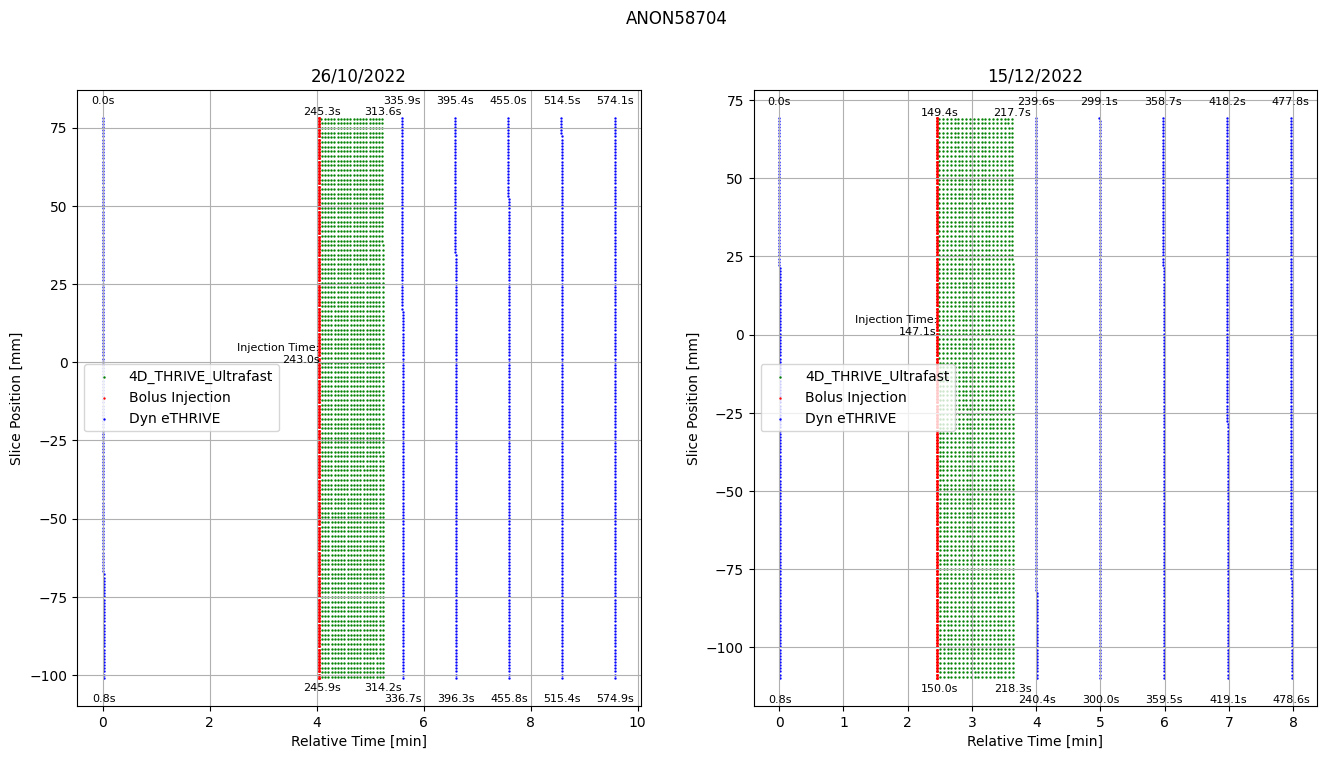

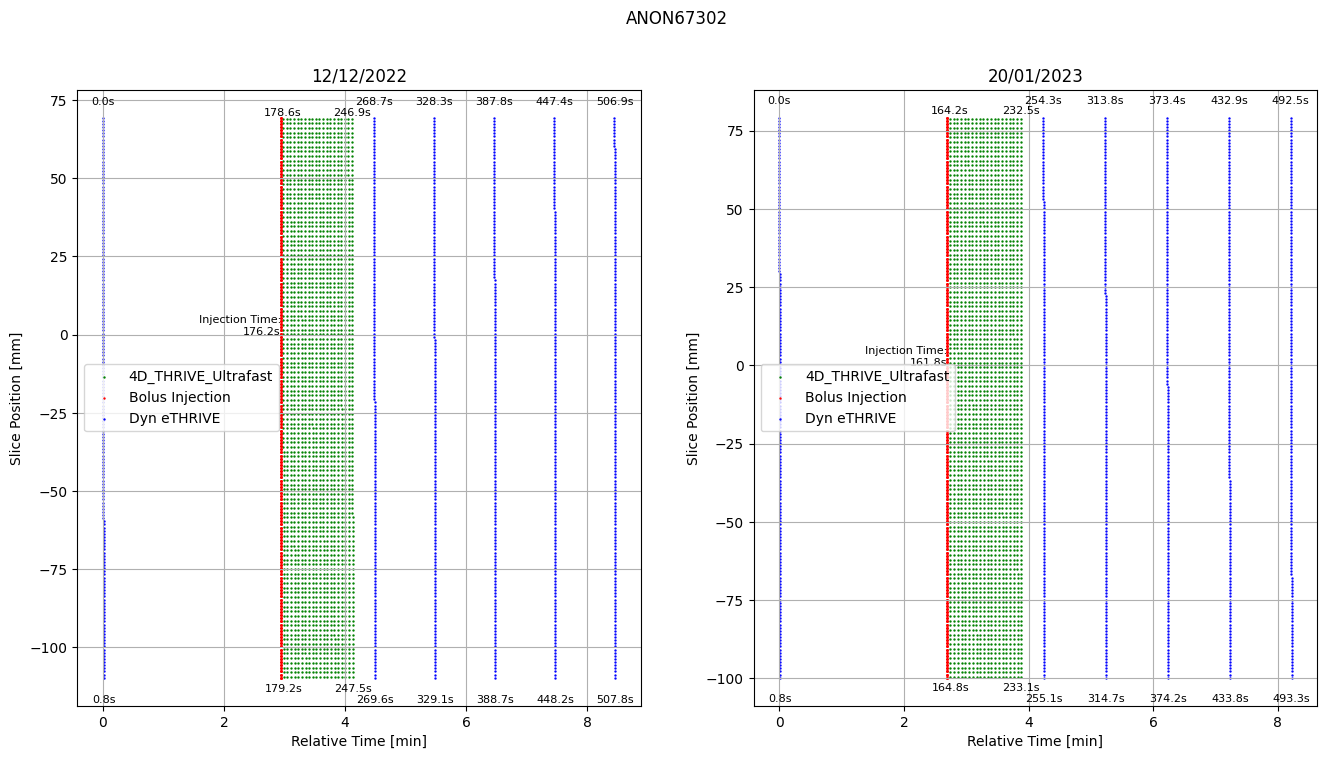

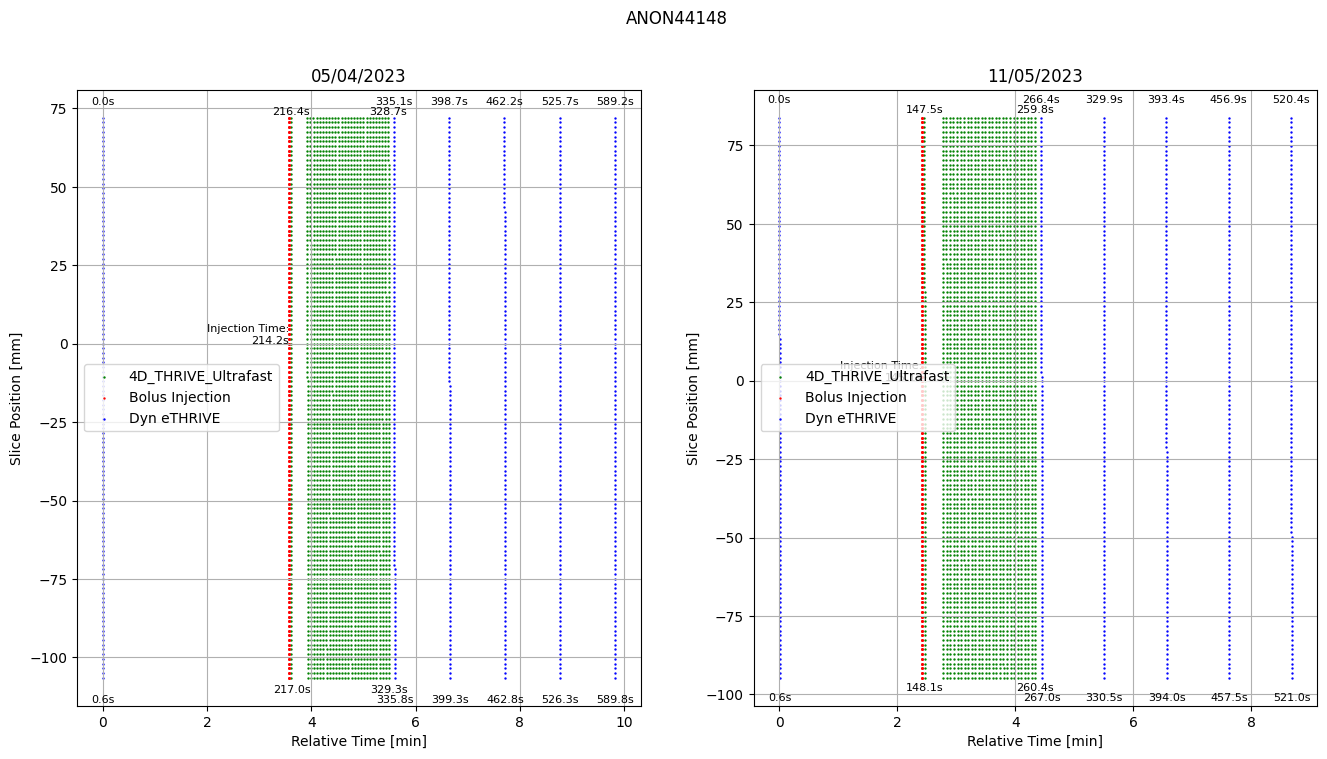

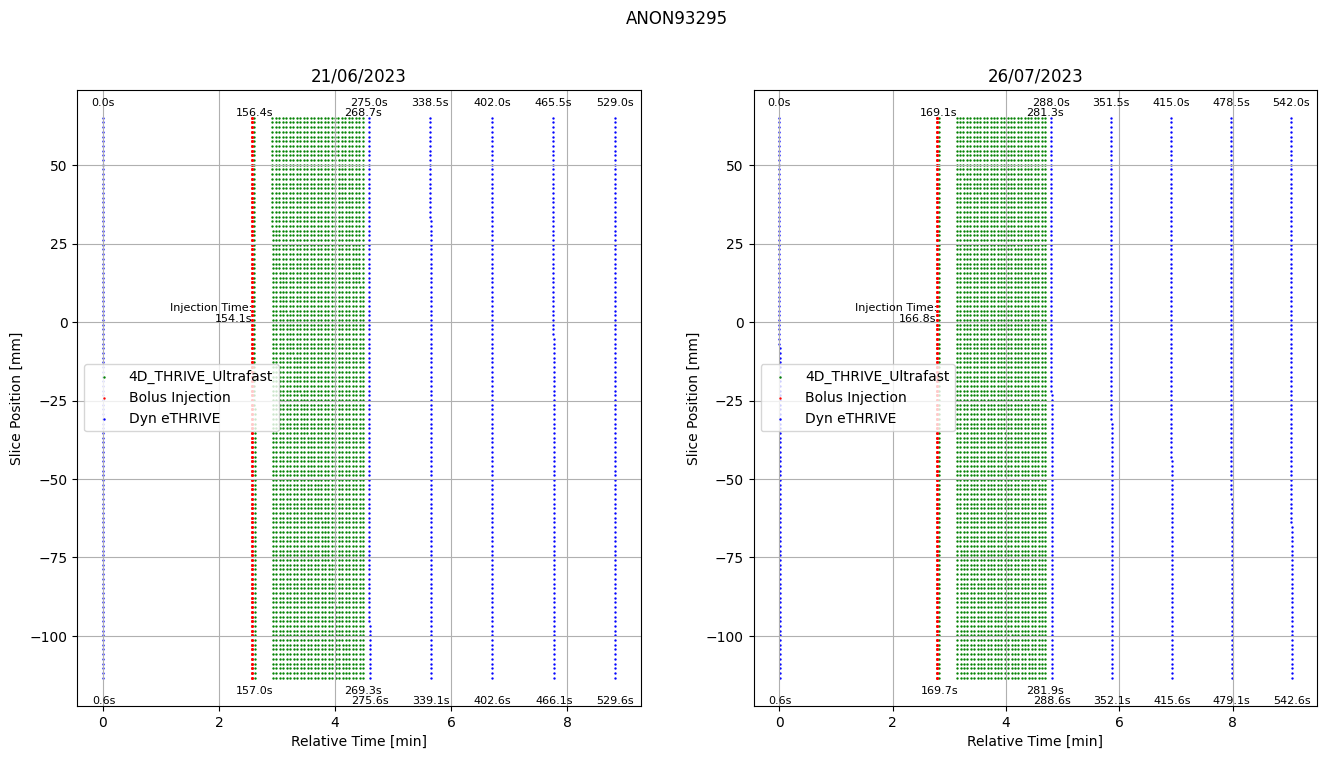

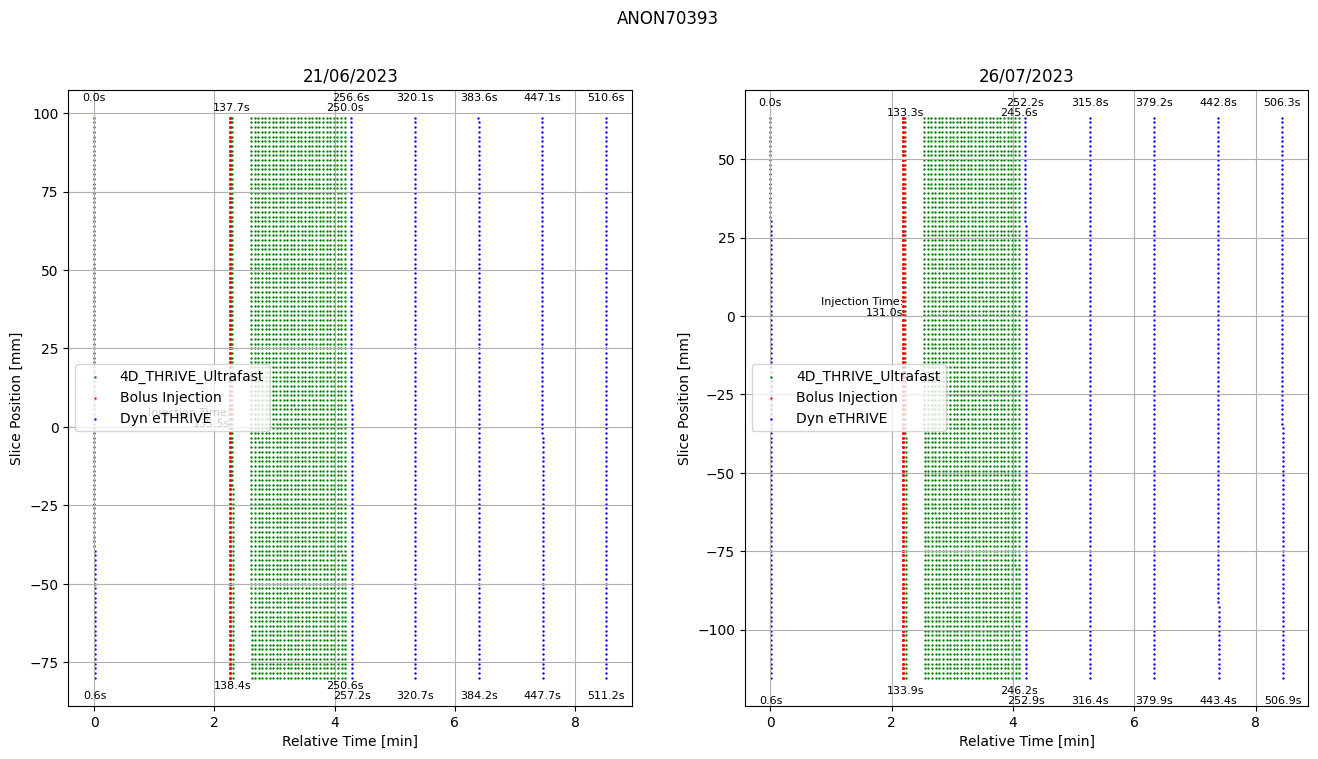

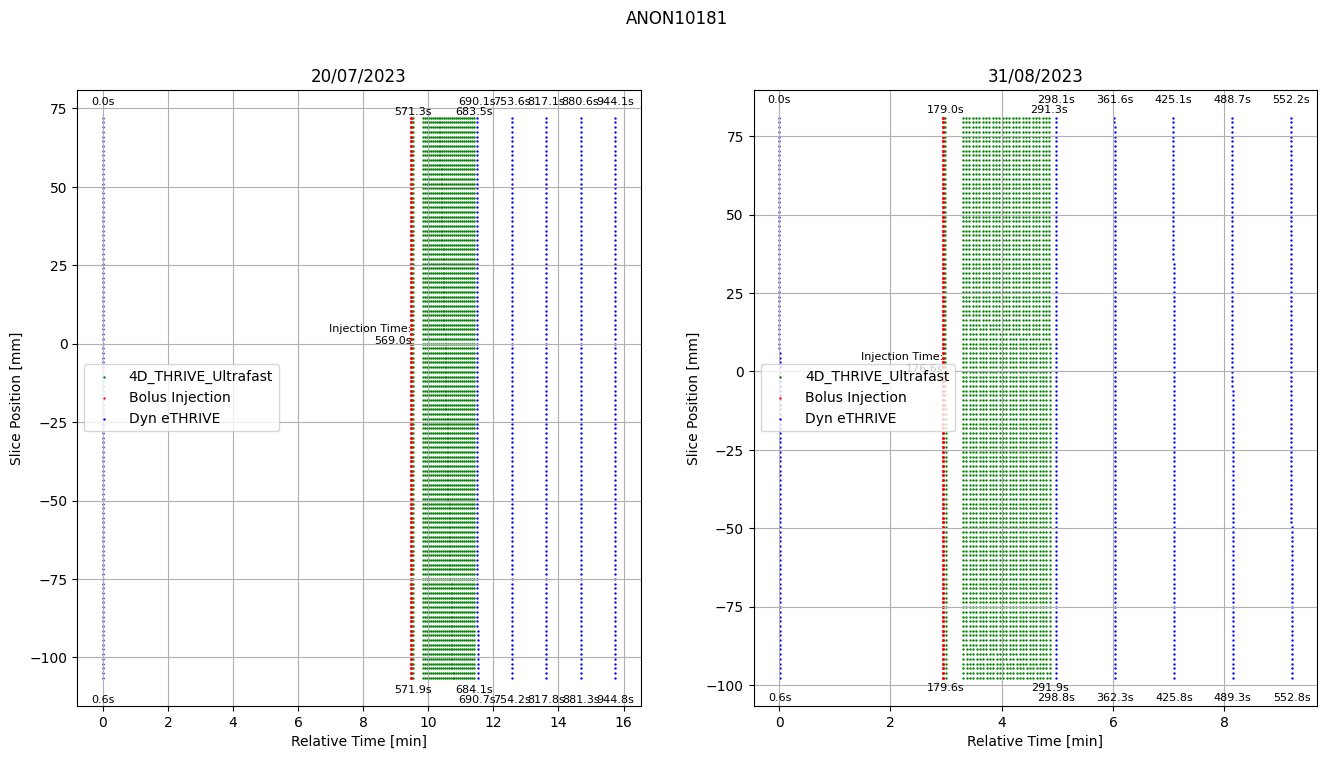

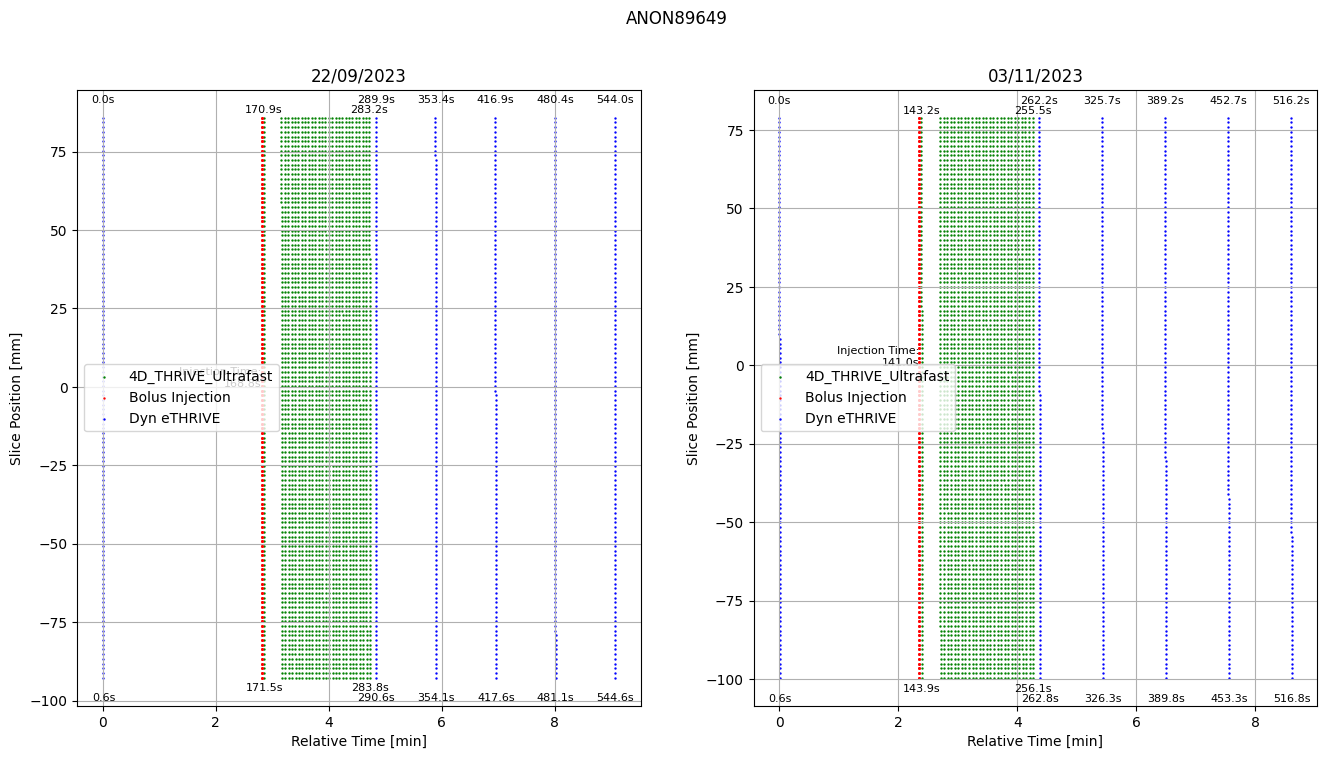

In [12]:
patients = df_metadata['PatientID'].unique().tolist()
# For each patient, we loop over the studies and sequences:
figsize = (8.0, 8.0)
markersize = 0.5
linestyle = '-'
nfigs = len(patients)
xplot_axis = {1: {'xaxis_field': 'perSliceAcquisitionTimeInMins',
                  'xaxis_units': 'm',
                  'xaxis_label': 'Relative Time [min]',
                  'bolus_xaxis': 'ContrastBolusStartTimeInMins'
                  },
              2: {'xaxis_field': 'perSliceAcquisitionTimeInSecs',
                  'xaxis_units': 's',
                  'xaxis_label': 'Relative Time [sec]',
                   'bolus_xaxis': 'ContrastBolusStartTimeInSecs'
                 },
              3: {'xaxis_field': 'perSliceAcquisitionDateTime',
                  'xaxis_units': '',
                  'xaxis_label': 'Date Time',
                  'bolus_xaxis': 'ContrastBolusStartDateTime'
              }
}

time_axis_field = xplot_axis[1]['xaxis_field']
time_axis_bolus_field = xplot_axis[1]['bolus_xaxis']
time_axis_xlabel = xplot_axis[1]['xaxis_label']

time_axis_label = xplot_axis[2]['xaxis_field']
time_axis_bolus_label = xplot_axis[2]['xaxis_field']
time_axis_units = xplot_axis[2]['xaxis_units']


for patientID in patients:
    # print(f'PatientID: {patientID}')
    patient_df = df_metadata[df_metadata['PatientID'].isin([patientID])]
    studies = patient_df['StudyDate'].unique().tolist()
    # print(f'\tStudies: {studies}')
    ncols = len(studies)
    nrows = 1 # overlay Ultrafast & HSR in a single plot
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=tuple([x*y for x,y in zip(figsize, [ncols, nrows])]))
    for idcol, study in enumerate(studies):
        patient_study_df = patient_df[patient_df['StudyDate'].isin([study])]
        sequences = patient_study_df['SeriesDescription'].unique().tolist()
        # print(f'\t\tSequences in study: {sequences}')
        # For each sequence, gets the timings and spatial locations for analysis:
        for sequence in sequences:
            dataset_df = patient_study_df[patient_study_df['SeriesDescription'].isin([sequence])]
            
            if sequence.startswith('4D_THRIVE'):
                colour = 'g'
                clr_bolus = ''
                vatop = 'top'
                vabottom = 'bottom'
            elif sequence.startswith('Dyn '):
                colour = 'b'
                clr_bolus = 'r'
                vatop = 'bottom'
                vabottom = 'top'
            else:
                colour = ''
            
            if colour:
                if clr_bolus:
                    dataset_df.plot(kind='scatter', 
                                    x=time_axis_bolus_field, y='SliceLocation', 
                                    c=clr_bolus, label='Bolus Injection', grid=True, s=markersize, linestyle=linestyle,
                                    ax=ax[idcol])
                dataset_df.plot(kind='scatter', title= f'{dtime.strptime(study, "%Y%m%d").strftime("%d/%m/%Y")}',
                                x=time_axis_field, y='SliceLocation', 
                                xlabel = time_axis_xlabel, ylabel='Slice Position [mm]',
                                c=colour, label=sequence, grid=True, s=markersize, linestyle=linestyle,
                                ax=ax[idcol])
                ax[idcol].legend(loc='center left')
                # ax[idcol].set_xlim([-0.001, 0.02])

                minSliceLoc, maxSliceLoc = [dataset_df['SliceLocation'].min(skipna=True), 
                                            dataset_df['SliceLocation'].max(skipna=True)]
                
                minTimepointLabel = dataset_df[dataset_df['SliceLocation'] == minSliceLoc]['perSliceAcquisitionTimeInSecs'].tolist()
                maxTimepointLabel = dataset_df[dataset_df['SliceLocation'] == maxSliceLoc]['perSliceAcquisitionTimeInSecs'].tolist()

                minTimepointAxis = dataset_df[dataset_df['SliceLocation'] == minSliceLoc][time_axis_field].tolist()
                maxTimepointAxis = dataset_df[dataset_df['SliceLocation'] == maxSliceLoc][time_axis_field].tolist()

                
                if sequence.startswith('4D_THRIVE'):
                    minTimepointLabel = [min(minTimepointLabel), max(minTimepointLabel)]
                    maxTimepointLabel = [min(maxTimepointLabel), max(maxTimepointLabel)]
                    minTimepointAxis = [min(minTimepointAxis), max(minTimepointAxis)]
                    maxTimepointAxis = [min(maxTimepointAxis), max(maxTimepointAxis)]
                elif sequence.startswith('Dyn '):
                    injectionTimeLabel = dataset_df['ContrastBolusStartTimeInSecs'].max(skipna=True)
                    injectionTime = dataset_df[time_axis_bolus_field].max(skipna=True)
                    ax[idcol].text(injectionTime, 0, f'Injection Time:\n{injectionTimeLabel:.1f}{time_axis_units}', 
                                   fontsize=8, ha='right')

                    
                for tpoint, zpoint, ttext in zip(minTimepointAxis, [(1-np.sign(minSliceLoc)*0.05)*minSliceLoc]*len(minTimepointLabel), minTimepointLabel):
                    ax[idcol].text(tpoint, zpoint, f'{ttext:.1f}{time_axis_units}', fontsize=8, ha='center', va=vabottom)
                for tpoint, zpoint, ttext in zip(maxTimepointAxis, [(1+np.sign(maxSliceLoc)*0.05)*maxSliceLoc]*len(maxTimepointLabel), maxTimepointLabel):
                    ax[idcol].text(tpoint, zpoint, f'{ttext:.1f}{time_axis_units}', fontsize=8, ha='center', va=vatop)
                
    fig.suptitle(patientID)
    fig.savefig(os.path.join(OUTPATH, f'Timings-{patientID}.png'))


# Signal Intensity QC

In [ ]:
# Extract the slice containing the aorta for QC dynamic signal intensity
# - Manually identified a representative slice for each of the 4D Ultrafast acquisition, got the slice location
# - Filter the instance numbers matching (or closest) to the slice location
# - Build a 3D (2D+time) array from where to take the signal intensity

# This list was manually identified from the sequences "4D Ultrafast" in Slicer3D, 
# the slice location was (manually) searched to match the closest value:

# Animation and path global parameters:
duration = 200 #ms
anatomy = 'aif' # other alternatives: 'aif', 'tumour'
SAVEPATH = os.path.join(OUTPATH, anatomy)


aorta_slices = pd.read_csv(os.path.join(OUTPATH, 'slice_references_aif.csv'))
tumour_slices = pd.read_csv(os.path.join(OUTPATH, 'slice_references_tumour.csv'))

# As usual, the date field causes issues, so ensure it is a string:
aorta_slices['StudyDate'] = aorta_slices['StudyDate'].astype(str)
tumour_slices['StudyDate'] = tumour_slices['StudyDate'].astype(str)


if anatomy == 'aif':
    selected_anatomy = aorta_slices.copy()
    xlims = [-20.0, 300.0]
elif anatomy == 'tumour':
    selected_anatomy = tumour_slices.copy()    
    xlims = [-10.0, 80.0]

selected_anatomy.head(n=20)


,PatientID,StudyDate,SequencePattern,ImagePatientPosZ,Cx,Cy,Radius,BaseLine
0,ANON58704,20221026,4D_THRIVE,-16.418100,315,405,15,3
1,ANON58704,20221215,4D_THRIVE,-4.419601,310,390,15,3
2,ANON67302,20221212,4D_THRIVE,-1.419632,357,555,15,3
3,ANON67302,20230120,4D_THRIVE,-8.099960,320,510,15,3
4,ANON44148,20230405,4D_THRIVE,1.473700,270,422,15,6
5,ANON44148,20230511,4D_THRIVE,-20.809900,299,432,15,5
6,ANON93295,20230621,4D_THRIVE,6.652527,265,425,15,6
7,ANON93295,20230726,4D_THRIVE,6.652527,278,441,15,6
8,ANON70393,20230621,4D_THRIVE,-44.039300,280,430,15,7
9,ANON70393,20230726,4D_THRIVE,-2.811401,290,450,15,7


In [46]:
for idx, (ref_slice_row_index, ref_slice_content) in enumerate(selected_anatomy.iterrows()):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5.0*2, 5.0*1))
    axr = ax.ravel()

    df_patient_study = df_metadata[ df_metadata['PatientID'].isin([ref_slice_content['PatientID']]) & 
                                   df_metadata['StudyDate'].isin([ref_slice_content['StudyDate']]) &
                                   df_metadata['SeriesDescription'].str.startswith(ref_slice_content['SequencePattern'])
                                   ]
    # Search only in the 1st Timepoint
    df_aux = df_patient_study[df_patient_study['TemporalPositionIdentifier'].isin([1])]    
    # Find the closest match within the ImagePatientPosZ:
    slice_location_target = ref_slice_content['ImagePatientPosZ']
    closest_index = (df_aux['z'] - slice_location_target).abs().idxmin()
    # closest_index = (df_aux['SliceLocation'] - slice_location_target).abs().idxmin()

    # And now, we can work with any other field in df_patient_study:
    # Retrieve the row with the closest match
    retrieved_slice_location = df_aux.loc[closest_index, 'SliceLocation']

    # And now, we can work with any other field in df_patient_study:
    df_time_course = df_patient_study[df_patient_study['SliceLocation'].isin([retrieved_slice_location])]
    df_time_course = df_time_course.sort_values(by=['TemporalPositionIdentifier'], ascending=True)

    signal_intensity = [None]* df_aux.loc[closest_index, 'NumberOfTemporalPositions']

    # create an animation of each dataset:
    # animated_dataset = cv2.Animation()
    frames = []
    durations = []

    for nti, individual_tpoint in df_time_course.iterrows():
        dcm_image_object_nti = dcm.dcmread(individual_tpoint['AbsFilePath'])
        dcm_image = dcm_image_object_nti.pixel_array
        # Populate frames and durations in the Animation object
        frames.append(dcm_image)
        durations.append(duration/1000) # in seconds for imageio
        # Convert it to 32bit and rescale it:
        dcm_image_32bit = dcm_image.astype(np.float32)
        # According to this thread https://stackoverflow.com/questions/67889762/what-is-the-difference-between-rescale-slope-intercept-and-scale-slope-inter
        # The forumalea relevant are:
        # D = R * RS + RI; R= raw pixel value, RS Rescale Slope (0028,1053), RI Rescale Intercept (0028,1052)
        # P = D / (RS * SS); D= Displayed Value (in the scanner screen), RS Rescale Slope (0028,1053), SS Scale Slope (2005,100E) "PhilipsScaleSlope"
        dcm_image_32bit *= individual_tpoint['RescaleSlope']
        dcm_image_32bit += individual_tpoint['RescaleIntercept']
        dcm_image_32bit /= (individual_tpoint['RescaleSlope'] * individual_tpoint['PhilipsScaleSlope'])

        if individual_tpoint['TemporalPositionIdentifier'] == 1:
            dcm_image_obj = dcm_image.copy()
        image_mask = np.zeros_like(dcm_image, dtype="uint8")
        cv2.circle(image_mask, tuple(ref_slice_content[['Cx', 'Cy']]), ref_slice_content['Radius'], [255]*1, -1)
        masked_image = cv2.bitwise_and(dcm_image, dcm_image, mask=image_mask)
        mean_signal_intensity, std_signal_intensity = cv2.meanStdDev(dcm_image_32bit, mask=image_mask)
        signal_intensity[individual_tpoint['TemporalPositionIdentifier']-1] = mean_signal_intensity.flatten()[0]

    # Save the animation frames and duration
    # animated_dataset.frames = frames
    # animated_dataset.durations = durations

    # Write the animation to file opencv
    # cv2.imwriteanimation(os.path.join(OUTPATH, f'{ref_slice_content["PatientID"]}-{ref_slice_content["StudyDate"]}.avif'), animated_dataset, [cv2.IMWRITE_WEBP_QUALITY, 100])    
    # Write the animation to file IMAGEIO
    imageio.mimsave(os.path.join(SAVEPATH, f'{ref_slice_content["PatientID"]}-{ref_slice_content["StudyDate"]}.gif'), frames, duration=durations)

    # Use the first image to display it:
    dcm_image_rgb = cv2.cvtColor(dcm_image_obj, cv2.COLOR_GRAY2RGB)
    cv2.circle(dcm_image_rgb, tuple(ref_slice_content[['Cx', 'Cy']]), ref_slice_content['Radius'], [0,255,0], 1)

    # Percentage of enhancement:
    percentage_enh = 100 * ( signal_intensity - np.mean(signal_intensity[:ref_slice_content['BaseLine']]) ) / np.mean(signal_intensity[:ref_slice_content['BaseLine']])
    signal_intensity = percentage_enh

    # Reference Time (T0):
    refT0 = df_time_course['ContrastBolusStartTimeInSecs'].unique().tolist()[0]

    axr[0].imshow(dcm_image_rgb)
    axr[0].plot(ref_slice_content['Cx'], ref_slice_content['Cy'], '.', color='y')
    axr[0].set_title(f'{dcm_image_object_nti[0x00100020].value}-{dcm_image_object_nti[0x00080020].value}')
    axr[0].text(0,0,f'Slice Location: {retrieved_slice_location:.2f}mm', color='w', va='top')

    axr[1].plot(df_time_course['perSliceAcquisitionTimeInSecs']-refT0, signal_intensity, '.-b')
    axr[1].set_title(f'{dcm_image_object_nti[0x00100020].value}-{dcm_image_object_nti[0x00080020].value}')
    axr[1].plot([df_time_course['ContrastBolusStartTimeInSecs'].unique().tolist()[0]-refT0]*2, 
                xlims, '-')
    axr[1].grid(True)
    axr[1].set_ylim(xlims)
    axr[1].set_ylabel('Percentage of Enhancement (%)')
    axr[1].set_xlabel('Time (Relative to HSR) [s]')

    fig.savefig(os.path.join(SAVEPATH, f'{ref_slice_content["PatientID"]}-{ref_slice_content["StudyDate"]}.png'))
    plt.close(fig)
